In [2]:
"""
Debug lenmap2gclm
"""
import numpy as np
import time
import healpy as hp
import matplotlib.pyplot as plt
import pysht
import cupy as cp
import sys
from time import process_time

from delensalot.sims.sims_lib import Xunl, Xsky
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

magnific = None
runinfos = [
    ("CPU", "lenspyx", 'ducc'),
    # ("CPU", "duccnufft", 'ducc'),
    ("GPU", "cufinufft", 'shtns')
    ]
epsilon = 1e-8
lmaxs = [1023]

phi_lmaxs = [lmax for lmax in lmaxs]
defres = {}
Tsky = None
Tsky2 = None
for lmax, phi_lmax in zip(lmaxs, phi_lmaxs):
    geominfo = ('gl',{'lmax': lmax})
    lenjob_geominfo = ('gl',{'lmax': phi_lmax})
    # geominfo = ('tgl',{'lmax': lmax, 'smax':2})
    # lenjob_geominfo = ('tgl',{'lmax': phi_lmax, 'smax':2})
    lldlm = np.arange(0, phi_lmax+1)
    synunl = Xunl(lmax=lmax, geominfo=geominfo, phi_lmax=phi_lmax)
    synsky = Xsky(lmax=lmax, unl_lib=synunl, geominfo=geominfo, lenjob_geominfo=geominfo, epsilon=epsilon)
    philm = synunl.get_sim_phi(0, space='alm')
    toydlm = hp.almxfl(philm, np.sqrt(np.arange(phi_lmax + 1, dtype=float) * np.arange(1, phi_lmax + 2)))
    toyunllm = synunl.get_sim_unl(0, spin=0, space='alm', field='temperature')
    Tsky = synsky.get_sim_sky(0, spin=0, space='map', field='temperature')
    Tsky2 = synsky.unl2len(toyunllm, philm, spin=0)
    # toyunllm = (np.random.random(size=hp.Alm.getsize(lmax, lmax)) +  np.random.random(size=hp.Alm.getsize(lmax, lmax))*1j)*1e-6
    # toydlm = (np.random.random(size=hp.Alm.getsize(lmax, lmax)) +  np.random.random(size=hp.Alm.getsize(lmax, lmax))*1j)*1e-6
    for runinfo in runinfos:
        shttransformer_desc = 'shtns' if runinfo[0] == 'GPU' else 'ducc'
        kwargs = {
            'geominfo': geominfo,
            'nthreads': 10,
            'epsilon': epsilon,
            'verbosity': 1,
            'planned': False,
            'single_prec': True,
            'shttransformer_desc': shttransformer_desc
        }
        
        deflection_kwargs = {
            'geominfo': lenjob_geominfo,
            'nthreads': 10,
            'epsilon': epsilon,
            'verbosity': 1,
            'single_prec': True,
            'mmax_dlm': phi_lmax,
            'dlm': toydlm,
        } 
        print(runinfo)
        backend = runinfo[0]
        defres.update({backend: {}}) if backend not in defres.keys() else None
        solver = runinfo[1]
        defres[backend].update({solver : None}) if solver not in defres[backend].keys() else None
        for mode in ['nuFFT']:
            print("\nTesting:: solver = {} backend = {} mode = {} ...".format(solver, backend, mode))
            t = pysht.get_transformer(solver, mode, backend)
            t = t(**kwargs, deflection_kwargs=deflection_kwargs)
            if runinfo[0] == 'CPU':
                magnific = t.deflectionlib.dlm2A()
            print(((lmax+1)*(lmax+1)), toyunllm.shape)
            print("\n----lmax: {}, phi_lmax: {}, dlm_lmax = {}, epsilon: {}----".format(lmax, phi_lmax, hp.Alm.getlmax(toydlm.size), deflection_kwargs['epsilon']))
            if backend == 'CPU':
                if solver == 'lenspyx':
                    defres[backend][solver] = t.lenmap2gclm(
                            np.atleast_2d(Tsky2.copy()), dlm=toydlm, lmax=lmax, mmax=lmax, spin=0, nthreads=10, execmode='debug', ptg=None)
                else:
                    defres[backend][solver] = t.lenmap2gclm(
                            np.atleast_2d(Tsky2.copy()), dlm=toydlm, lmax=lmax, mmax=lmax, spin=0, nthreads=10, execmode='debug')
            elif backend == 'GPU':
                defres[backend][solver] = t.lenmap2gclm(np.atleast_2d(Tsky2.copy()*magnific), dlm=toydlm, lmax=lmax, mmax=lmax, spin=0, nthreads=10, execmode='debug')

INFO:: 04-18 15:48:24:: delensalot.sims.sims_lib.__init__ - sht_solver not given, defaulting to ducc
INFO:: 04-18 15:48:24:: delensalot.sims.sims_lib.__init__ - sht_backend not given, defaulting to CPU
INFO:: 04-18 15:48:24:: delensalot.sims.sims_lib.__init__ - sht_solver not given, defaulting to ducc
INFO:: 04-18 15:48:24:: delensalot.sims.sims_lib.__init__ - sht_backend not given, defaulting to CPU
1024 1024 1024 1024
inside _build_d1
lmax_dlm:  1023
mmax_dlm:  1023
----
shape d1:  (2, 2097152)
-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~
shape d1:  (2, 2097152)
lmax_dlm:  1023
mmax_dlm:  1023
shapes:  (1024,) (1024,) (1024,) (1024,) (2, 2097152)
(2097152, 3)
CPU_SHT_DUCC_transformer.synthesis
  Input shapes:
    self: ()
    gclm: (524800,)
    spin: ()
    lmax: ()
    mmax: ()
    nthreads: ()
  Output shape: [(2097152,)], types: [<class 'numpy.ndarray'>]
1024 1024 1024 1024
inside _build_d1
lmax_dlm:  1023
mmax_dlm:  1023
----
shape d1:  (2, 2097152)
-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-


Total wall clock time for adjoint_synthesis_general: 0.05808s
|
+- deinterpol (nu2u)                 : 63.06% (0.0366s)
+- updateAlm                         : 35.53% (0.0206s)
|  |
|  +- leg2alm                           : 62.14% (0.0128s)
|  +- theta resampling and deconvolution: 21.48% (0.0044s)
|  +- phi FFT and deconvolution         : 15.74% (0.0032s)
|  +- dealing with borders              :  0.61% (0.0001s)
|  
+- build_planes                      :  1.18% (0.0007s)
+- SphereInterpol setup              :  0.23% (0.0001s)
+- setup                             :  0.00% (0.0000s)


        => using FFTW : Mmax=1023, Nphi=2048, Nlat=1024, Nbatch=1  (theta-contiguous layout: phi_inc=1024, theta_inc=1)
          fftw cost ifftc=1.01597e+07,  fftc=1.01597e+07
          Memory used for Ylm and Zlm matrices = 6150.000 Mb x2
        => using Gauss nodes
          Sum of weights = 2 + 0 (should be 2)
          Applying quadrature rule to 3/2.x^2 = 1 + 1.44329e-15 (should be 1)
          Applying quadrature rule to 3/4.sin2(theta) = 1 + 4.44089e-16 (should be 1)
 NLAT=1024, NLAT_2=512
          max zero at Gauss nodes for Pl[l=NLAT] : 1.21011e-12
        + polar optimization threshold = 1.0e-10
          tm[im]= 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 2 2 2 2 2 3 3 3 3 3 4 4 4 4 4 5 5 5 5 6 6 6 6 6 7 7 7 7 8 8 8 8 9 9 9 9 10 10 10 10 11 11 11 11 12 12 12 12 13 13 13 14 14 14 14 15 15 15 15 16 16 16 16 17 17 17 18 18 18 18 19 19 19 19 20 20 20 21 21 21 21 22 22 22 22 23 23 23 24 24 24 24 25 25 25 26 26 26 26 27 27 27 28 28 28 28 29 29 29 29 30 30 30 31 31 31 31 32 32 3

/mnt/home/sbelkner/git/pySHT/pysht/deflection/GPU_nufft_transformer.py:110: RuntimeWarning: divide by zero encountered in divide
  scaled = hp.almxfl(dlm, np.nan_to_num(np.sqrt(1/(ll*(ll+1)))))


(1, 2097152) (2097152,) (2097152,)
GPU_cufinufft_transformer.nuFFT
  Input shapes:
    self: ()
    lenmap: (1, 2097152)
    ptg_theta: (2097152,)
    ptg_phi: (2097152,)
    fc: (2,)
  Output shape: [(2062, 2048)], types: [<class 'cupy.ndarray'>]
- - - - - - - - - - - - - - - Timing nuFFT: 0.548 seconds- - - - - - - - - - - - - - - 

GPU_cufinufft_transformer.C2C
  Input shapes:
    self: ()
    fc: (2062, 2048)
    map_out: ()
  Output shape: [(2062, 2048)], types: [<class 'cupy.ndarray'>]
- - - - - - - - - - - - - - - Timing C2C: 0.006 seconds- - - - - - - - - - - - - - - 

Types:  <class 'cupy.ndarray'> <class 'int'> <class 'int'> <class 'cupy.ndarray'>
dtypes:  float64 float64
shapes:  (4222976,) (2113536,)
GPU_cufinufft_transformer.adjoint_doubling
  Input shapes:
    self: ()
    CARdmap: (4222976,)
    CARmap: (2113536,)
  Output shape: [(2113536,)], types: [<class 'cupy.ndarray'>]
- - - - - - - - - - - - - - - Timing adjointdoubling: 0.005 seconds- - - - - - - - - - - - - - - 

/mnt/home/sbelkner/git/pySHT/pysht/deflection/GPU_nufft_transformer.py:351: ComplexWarning: Casting complex values to real discards the imaginary part
  synthmap = adjoint_doubling(self, CARdmap.flatten().astype(np.double), CARmap)[0]


In [3]:
from lenspyx.tests.helper import syn_ffi_ducc_29, cls_unl
from lenspyx.utils import timer
from lenspyx.utils_hp import Alm, synalm
import numpy as np
import pylab as pl
import healpy as hp

tim = timer(True)
ffi, _ = syn_ffi_ducc_29(lmax_len=1023, dlmax=0, dlmax_gl=0, dlm=toydlm, epsilon=epsilon)
tim.add('ffi gen.')
Aunl = ffi.dlm2A()

lmax, mmax = 1023, 1023
# tlm_unl = synalm(cls_unl['tt'][:lmax + 1], lmax, mmax).astype(np.complex64)
tmap_len = ffi.gclm2lenmap(toyunllm, mmax, 0, backwards=False)
tim.add('gen and lensing of Tlm')

points1 = tmap_len.copy()
for ofs, w, nph in zip(ffi.geom.ofs, ffi.geom.weight, ffi.geom.nph):
    points1[ofs:ofs + nph] *= w
points1 = points1
points2 = tmap_len * Aunl
for ofs, w, nph in zip(ffi.geom.ofs, ffi.geom.weight, ffi.geom.nph):
    points2[ofs:ofs + nph] *= w
points2 = points2
tim.add('weighting')

tlm_unl_1 = ffi.lenmap2gclm(points1, 0, lmax, mmax).astype(np.complex128)
tlm_unl_2 = ffi.lenmap2gclm(points2, 0, lmax, mmax).astype(np.complex128)
tim.add('delensing two maps')

deflection std is 2.58e+00 amin
1024 1024 1024 1024
deflection: I set numthreads to 40
 DUCC 40 threads deflection instantiated 1e-08
inside _build_d1
lmax_dlm:  1023
mmax_dlm:  1023
----
shape d1:  (2, 1521160)
-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~
shape d1:  (2, 1521160)
lmax_dlm:  1023
mmax_dlm:  1023
shapes:  (1024,) (1024,) (1024,) (1024,) (2, 1521160)
(1521160, 3)
  dlm2A                                :  [0:00:00.184107] (64.7%)  
  build angles <- synthesis (GRAD_ONLY):  [0:00:00.040869] (14.4%)  
  build angles <- th-phi-gm (ducc)     :  [0:00:00.011889] (4.2%)  
  build_angles                         :  [0:00:00.052776] (18.5%)  
  synthesis general (STANDARD)         :  [0:00:00.047205] (16.6%)  
  gclm2lenmap                          :  [0:00:00.100090] (35.2%)  
  Total                                :  [0:00:00.284645] d:h:m:s:mus
shapes:  (1, 1521160) (1521160, 2) [[-4.88414591e-06 -4.91746307e-06 -4.93026526e-06 ... -1.46920744e-05
  -1.50744060e-05 -1.54690509e-05]]


Total wall clock time for synthesis_general: 0.04668s
|
+- getPlane                          : 56.26% (0.0263s)
|  |
|  +- alm2leg                           : 64.29% (0.0169s)
|  +- theta resampling and deconvolution: 21.60% (0.0057s)
|  +- phi FFT and dconvolution          : 13.39% (0.0035s)
|  +- dealing with borders              :  0.69% (0.0002s)
|  
+- interpol (u2nu)                   : 43.36% (0.0202s)
+- SphereInterpol setup              :  0.34% (0.0002s)
+- build_planes                      :  0.03% (0.0000s)
+- setup                             :  0.00% (0.0000s)

Total wall clock time for adjoint_synthesis_general: 0.04717s
|
+- deinterpol (nu2u)                 : 53.50% (0.0252s)
+- updateAlm                         : 43.33% (0.0204s)
|  |
|  +- leg2alm                           : 63.34% (0.0129s)
|  +- theta resampling and deconvolution: 20.89% (0.0043s)
|  +- phi FFT and deconvolution         : 15.11% (0.0031s)
|  +- dealing with borders              :  0.62% (0.0001s)


[]

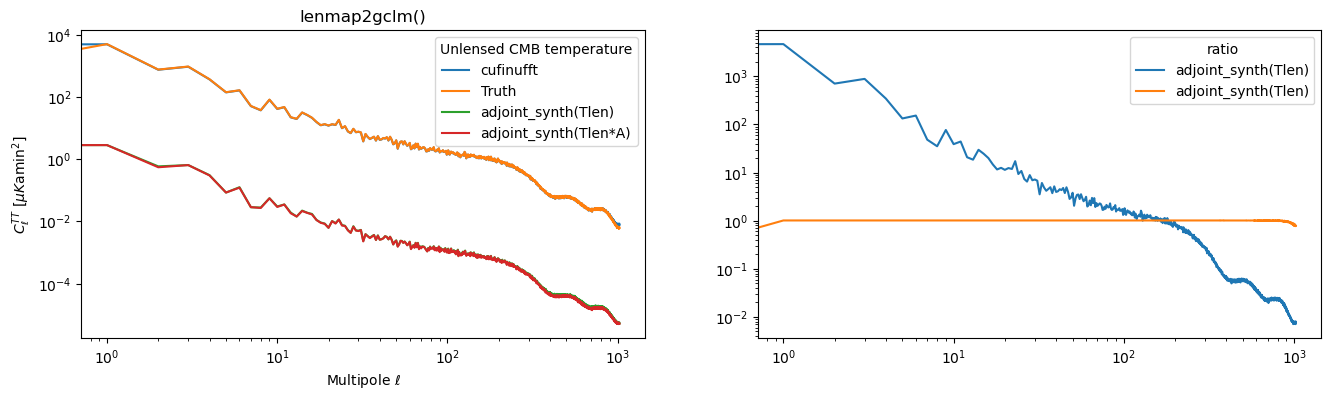

In [9]:
key = 'adjointsynthesis'
solverCPU, solverGPU = 'lenspyx', 'cufinufft'
vmin=-1e-10
vmax=1e-10
fig, ax = plt.subplots(1,2, figsize=(16,4))
# print(defres['CPU'][solverCPU][key][0][0].shape)

# ax[0].plot(hp.alm2cl(defres['CPU'][solverCPU][key][0][0]), label=solverCPU)
ax[0].plot(hp.alm2cl(defres['GPU'][solverGPU][key][0]), label=solverGPU)
ax[0].plot(hp.alm2cl(toyunllm), label='Truth')

ax[0].plot(hp.alm2cl(tlm_unl_1.astype(complex)), label='adjoint_synth(Tlen)')
ax[0].plot(hp.alm2cl(tlm_unl_2.astype(complex)), label='adjoint_synth(Tlen*A)')

ax[0].legend(title='Unlensed CMB temperature')
ax[0].loglog()
ax[0].set_title('lenmap2gclm()')

ax[0].set_xlabel(r'Multipole $\ell$')
ax[0].set_ylabel(r'$C_\ell^{TT}\ [\mu K {\rm amin}^2]$')

# ax[1].plot(hp.alm2cl(defres['CPU'][solverCPU][key][0][0]-defres['GPU'][solverGPU][key][0]), label=solverCPU)
ax[1].plot(hp.alm2cl(tlm_unl_2.astype(complex)-defres['GPU'][solverGPU][key][0]), label='adjoint_synth(Tlen)')
ax[1].plot(hp.alm2cl(toyunllm)/hp.alm2cl(defres['GPU'][solverGPU][key][0]), label='adjoint_synth(Tlen)')
ax[1].legend(title='ratio')
ax[1].loglog()
# ax[1].plot(hp.alm2cl(), label=solverGPU)

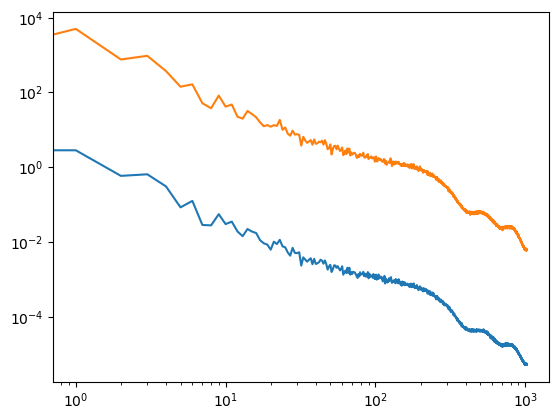

  ffi gen.              :  [0:00:00.007679] (0.0%)  
  gen and lensing of Tlm:  [0:00:00.284753] (0.1%)  
  weighting             :  [0:00:00.011179] (0.0%)  
  delensing two maps    :  [0:00:00.100642] (0.0%)  
  Total                 :  [0:07:39.677970] d:h:m:s:mus


In [11]:
plt.plot(hp.alm2cl(tlm_unl_1))
plt.plot(hp.alm2cl(toyunllm))
# plt.plot(hp.alm2cl(toyunllm - tlm_unl_1))
# plt.plot(hp.alm2cl(toyunllm - tlm_unl_2))
plt.loglog()
plt.show()

print(tim)

## Compare with lenpyx test

KeyError: 'lenspyx'

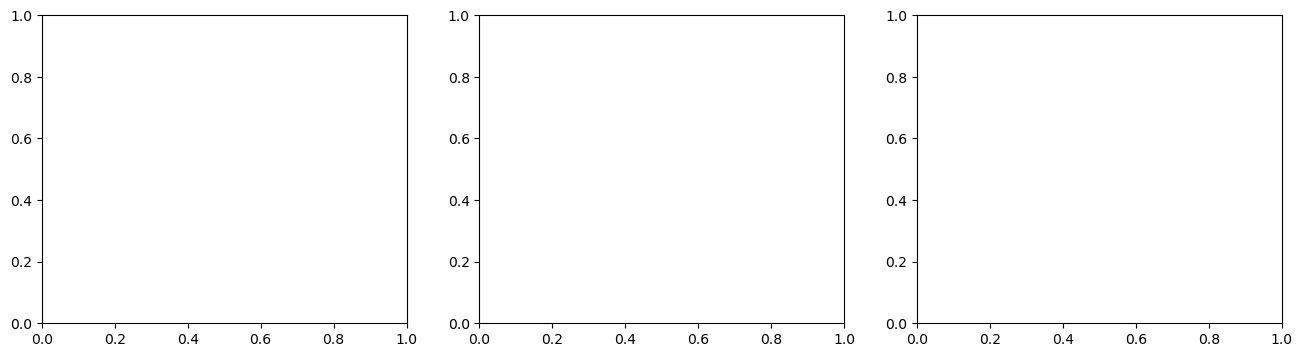

In [3]:
key = 'adjointsynthesis'
solverCPU, solverGPU = 'lenspyx', 'duccnufft'
vmin=-1e-10
vmax=1e-10
fig, ax = plt.subplots(1,3, figsize=(16,4))
print(defres['CPU'][solverCPU]["adjointsynthesisgeneral"][0][0].shape)

# ax[0].plot(hp.alm2cl(defres['CPU'][solverCPU]["adjointsynthesisgeneral"][0][0]), label=solverCPU)
ax[0].plot(hp.alm2cl(defres['CPU'][solverGPU][key][0][0]), label=solverGPU)
ax[0].plot(hp.alm2cl(toyunllm), label='Truth')

ax[0].plot(hp.alm2cl(tlm_unl_1.astype(complex)), label='adjoint_synth(Tlen)')
ax[0].plot(hp.alm2cl(tlm_unl_2.astype(complex)), label='adjoint_synth(Tlen*A)')

ax[0].legend(title='Unlensed CMB temperature')
ax[0].loglog()
ax[0].set_title('lenmap2gclm()')

ax[0].set_xlabel(r'Multipole $\ell$')
ax[0].set_ylabel(r'$C_\ell^{TT}\ [\mu K {\rm amin}^2]$')

ax[1].plot(hp.alm2cl(tlm_unl_1.astype(complex))/hp.alm2cl(tlm_unl_2.astype(complex)), label='adjoint_synth(Tlen)')
ax[1].set_ylim(0.99,1.21)

ax[2].plot(Tsky2-tmap_len[0])
ax[2].set_xlim(0,10000)

# CPU vs GPU

## Only for lenpsyx

In [ ]:
keyGPU = 'nuFFT'
keyCPU = 'synthesisgeneral'
# Tsky = Tsky2

vmin, vmax = -4e2, 4e2
resCPU = defres['CPU']['lenspyx'][keyCPU].real
resGPU = resCPU #defres['GPU'][keyGPU][0].real

fig, ax = plt.subplots(2,3, figsize=(16,6))

ax[0,0].imshow(Tsky.reshape(lmax+1,-1), vmin=vmin, vmax=vmax)
ax[0,0].set_title('Tsky')

ax[0,1].imshow(resCPU.reshape(lmax+1,-1), vmin=vmin, vmax=vmax)
ax[0,1].set_title('CPU')

im = ax[0,2].imshow(resGPU.reshape(lmax+1,-1), vmin=vmin, vmax=vmax)
ax[0,2].set_title('GPU')
divider = make_axes_locatable(ax[0,2])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')


im = ax[1,0].imshow(((resCPU-resGPU).reshape(lmax+1,-1)), vmin=-1e-8, vmax=1e-8)
ax[1,0].set_title('CPU - GPU')
divider = make_axes_locatable(ax[1,0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

im = ax[1,1].imshow(((Tsky-resCPU).reshape(lmax+1,-1)), vmin=-1e-5, vmax=1e-5)
ax[1,1].set_title('Tsky - CPU')
divider = make_axes_locatable(ax[1,1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

im = ax[1,2].imshow(((Tsky-resGPU).reshape(lmax+1,-1)), vmin=-1e-2, vmax=1e-2)
divider = make_axes_locatable(ax[1,2])
ax[1,2].set_title('Tsky - GPU')
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

In [ ]:
keyGPU = 'dlm2pointing'
keyCPU = 'pointing'
solverCPU, solverGPU = 'lenspyx', 'duccnufft'

print(defres['CPU'][solverGPU][keyGPU].shape, defres['CPU'][solverCPU][keyCPU].shape)

fig, ax = plt.subplots(3,2, figsize=(10,10))

ax[0,0].imshow(defres['CPU'][solverCPU][keyCPU][0].T[0,:].reshape(lmax+1,-1))
ax[0,1].imshow(defres['CPU'][solverGPU][keyGPU].T[:,0].reshape(lmax+1,-1))

ax[1,0].imshow(defres['CPU'][solverCPU][keyCPU][0].T[1,:].reshape(lmax+1,-1))
ax[1,1].imshow(defres['CPU'][solverGPU][keyGPU].T[:,1].reshape(lmax+1,-1))

ax[2,0].imshow(defres['CPU'][solverCPU][keyCPU][0].T[0,:].reshape(lmax+1,-1) - defres['CPU'][solverGPU][keyGPU].T[:,0].reshape(lmax+1,-1), cmap='PiYG', vmin=-1e-15, vmax=1e-15)
ax[2,1].imshow(defres['CPU'][solverCPU][keyCPU][0].T[1,:].reshape(lmax+1,-1) - defres['CPU'][solverGPU][keyGPU].T[:,1].reshape(lmax+1,-1), cmap='PiYG', vmin=-1e-15, vmax=1e-15)

In [ ]:
keyGPU = 'dlm2pointing'
keyCPU = 'pointing'
solverCPU, solverGPU = 'lenspyx', 'cufinufft'

print(defres['GPU'][solverGPU][keyGPU].shape, defres['CPU'][solverCPU][keyCPU].shape)

fig, ax = plt.subplots(3,2, figsize=(10,10))

ax[0,0].imshow(defres['CPU'][solverCPU][keyCPU][0].T[0,:].reshape(lmax+1,-1))
ax[0,1].imshow(defres['GPU'][solverGPU][keyGPU].T[:,0].reshape(lmax+1,-1))

ax[1,0].imshow(defres['CPU'][solverCPU][keyCPU][0].T[1,:].reshape(lmax+1,-1))
ax[1,1].imshow(defres['GPU'][solverGPU][keyGPU].T[:,1].reshape(lmax+1,-1))

ax[2,0].imshow(defres['CPU'][solverCPU][keyCPU][0].T[0,:].reshape(lmax+1,-1) - defres['GPU'][solverGPU][keyGPU].T[:,0].reshape(lmax+1,-1), cmap='PiYG', vmin=-1e-15, vmax=1e-15)
ax[2,1].imshow(defres['CPU'][solverCPU][keyCPU][0].T[1,:].reshape(lmax+1,-1) - defres['GPU'][solverGPU][keyGPU].T[:,1].reshape(lmax+1,-1), cmap='PiYG', vmin=-1e-15, vmax=1e-15)

In [ ]:
defres['CPU'].keys()

# all others

### pointing things

In [5]:
defres['GPU'][solverGPU].keys(), defres['CPU'][solverCPU].keys()

(dict_keys(['nuFFT', 'C2C', 'adjointdoubling', 'adjointsynthesis']),
 dict_keys(['nuFFT', 'C2C', 'adjointdoubling', 'adjointsynthesis']))

In [ ]:
key = 'dlm2pointing'
solverCPU, solverGPU = 'duccnufft', 'cufinufft'
print(defres['GPU'][solverGPU][key].shape, defres['CPU'][solverCPU][key].shape)
vmin, vmax = -1e-15, 1e-15
fig, ax = plt.subplots(3,2, figsize=(10,10))

ax[0,0].imshow(defres['CPU'][solverCPU][key][0,:].reshape(phi_lmax+1,-1))
ax[0,1].imshow(defres['GPU'][solverGPU][key].T[:,0].reshape(phi_lmax+1,-1))

ax[1,0].imshow(defres['CPU'][solverCPU][key][1,:].reshape(phi_lmax+1,-1))
ax[1,1].imshow(defres['GPU'][solverGPU][key].T[:,1].reshape(phi_lmax+1,-1))

ax[2,0].imshow(defres['CPU'][solverCPU][key][0,:].reshape(phi_lmax+1,-1) - defres['GPU'][solverGPU][key].T[:,0].reshape(phi_lmax+1,-1), cmap='PiYG', vmin=vmin, vmax=vmax)
ax[2,1].imshow(defres['CPU'][solverCPU][key][1,:].reshape(phi_lmax+1,-1) - defres['GPU'][solverGPU][key].T[:,1].reshape(phi_lmax+1,-1), cmap='PiYG', vmin=vmin, vmax=vmax)

## synthesis general

(1, 2062, 2048) (1, 2062, 2048)


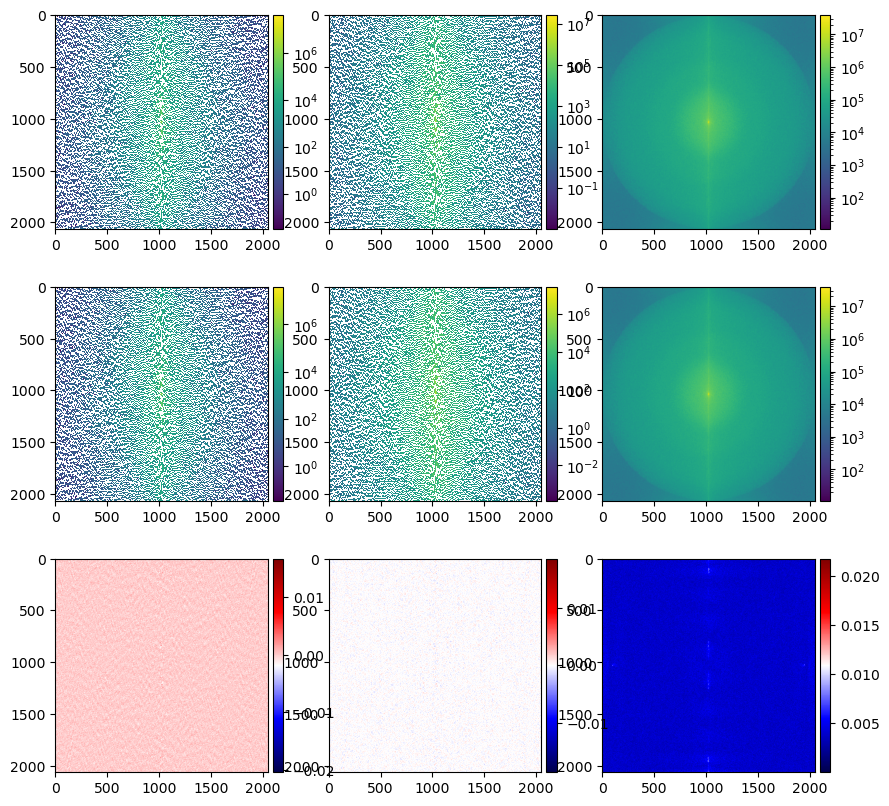

In [2]:
key = 'nuFFT'
solverCPU, solverGPU = 'duccnufft', 'cufinufft'
# print(defres['GPU'][solverGPU][key].shape, defres['CPU'][solverCPU][key].shape)
print(defres['GPU'][solverGPU][key].shape, defres['CPU'][solverCPU][key].shape)

vmin, vmax = -1e-10, 1e-10
fig, ax = plt.subplots(3,3, figsize=(10,10))

im = ax[0,0].imshow(np.real(np.fft.fftshift(defres['CPU'][solverCPU][key][0],axes=(0,1))).reshape(2*t.ntheta_CAR-2,-1), norm='log')
divider = make_axes_locatable(ax[0,0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
im = ax[0,1].imshow(np.imag(np.fft.fftshift(defres['CPU'][solverCPU][key][0],axes=(0,1))).reshape(2*t.ntheta_CAR-2,-1), norm='log')
divider = make_axes_locatable(ax[0,1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
im = ax[0,2].imshow(np.abs(np.fft.fftshift(defres['CPU'][solverCPU][key][0],axes=(0,1))), norm='log')
divider = make_axes_locatable(ax[0,2])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')


im = ax[1,0].imshow(np.real(defres['GPU'][solverGPU][key][0].reshape(2*t.ntheta_CAR-2,-1)), norm='log')
divider = make_axes_locatable(ax[1,0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

im = ax[1,1].imshow(np.imag(defres['GPU'][solverGPU][key][0].reshape(2*t.ntheta_CAR-2,-1)), norm='log')
divider = make_axes_locatable(ax[1,1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

im = ax[1,2].imshow(np.abs(defres['GPU'][solverGPU][key][0].reshape(2*t.ntheta_CAR-2,-1)), norm='log')
divider = make_axes_locatable(ax[1,2])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')


vmin, vmax = -1e1, 1e1
vmin, vmax = None, None
im = ax[2,0].imshow(np.real(np.fft.fftshift(defres['CPU'][solverCPU][key][0],axes=(0,1))-defres['GPU'][solverGPU][key][0].reshape(2*t.ntheta_CAR-2,-1)), vmin=vmin, vmax=vmax, cmap='seismic')
divider = make_axes_locatable(ax[2,0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

im = ax[2,1].imshow(np.imag(np.fft.fftshift(defres['CPU'][solverCPU][key][0],axes=(0,1))-defres['GPU'][solverGPU][key][0].reshape(2*t.ntheta_CAR-2,-1)), vmin=vmin, vmax=vmax, cmap='seismic')
divider = make_axes_locatable(ax[2,1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

im = ax[2,2].imshow(np.abs(np.fft.fftshift(defres['CPU'][solverCPU][key][0],axes=(0,1))-defres['GPU'][solverGPU][key][0].reshape(2*t.ntheta_CAR-2,-1)), vmin=vmin, vmax=vmax, cmap='seismic')
divider = make_axes_locatable(ax[2,2])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

(1, 2062, 2048) (1, 2062, 2048)


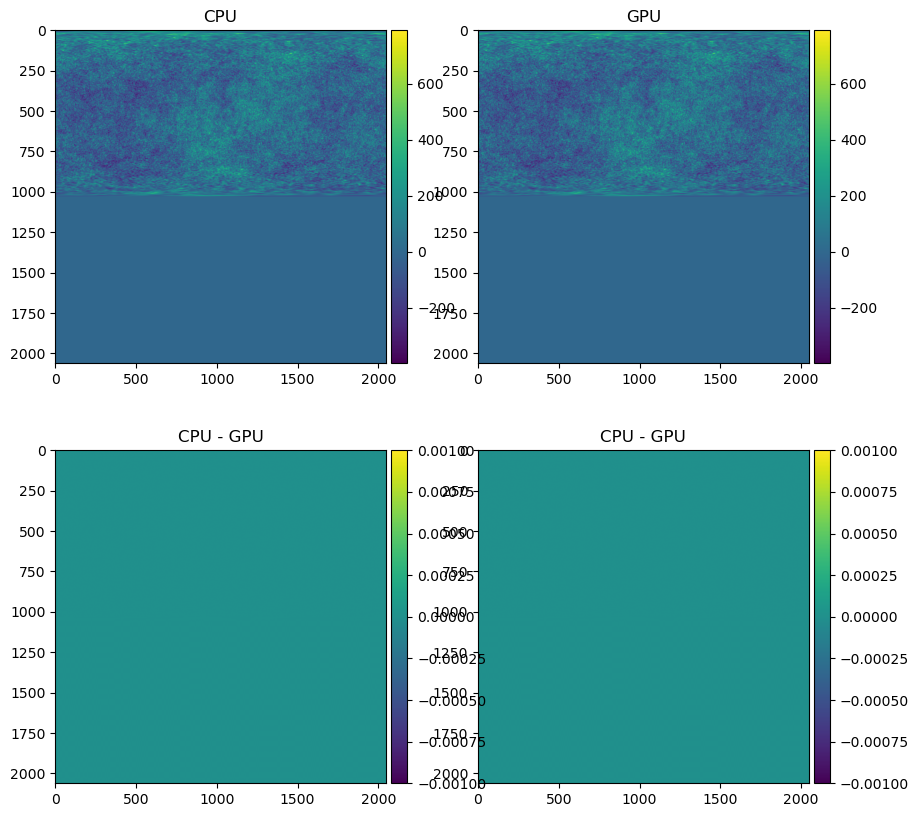

In [4]:
key = 'C2C'
solverCPU, solverGPU = 'duccnufft', 'cufinufft'

vmin, vmax = -4e2, 4e2
vmin, vmax = None, None
print(defres['GPU'][solverGPU][key].shape, defres['CPU'][solverCPU][key].shape)
Tsky = Tsky2

resCPU = np.real(defres['CPU'][solverCPU][key][0])#[::2,::2])
resGPU = np.real(defres['GPU'][solverGPU][key][0])#[::2,::2])
n=1

fig, ax = plt.subplots(2,2, figsize=(10,10))

# ax[0,0].imshow(Tsky[:500*(t.nphi_CAR)].reshape(-1,t.nphi_CAR).real, vmin=vmin, vmax=vmax)
# ax[0,0].imshow(Tsky.reshape(2*t.ntheta_CAR-2,t.nphi_CAR), vmin=vmin, vmax=vmax)
# ax[0,0].set_title('Tsky')

im = ax[0,0].imshow(resCPU.reshape((2*t.ntheta_CAR-2)//n,t.nphi_CAR//n), vmin=vmin, vmax=vmax)
ax[0,0].set_title('CPU')
divider = make_axes_locatable(ax[0,0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

im = ax[0,1].imshow(resGPU.reshape((2*t.ntheta_CAR-2)//n,t.nphi_CAR//n).astype(np.double), vmin=vmin, vmax=vmax)
ax[0,1].set_title('GPU')
divider = make_axes_locatable(ax[0,1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')


vmin, vmax = -1e-3, 1e-3
im = ax[1,0].imshow((resCPU-resGPU).reshape(-1,t.nphi_CAR), vmin=vmin, vmax=vmax)
ax[1,0].set_title('CPU - GPU')
divider = make_axes_locatable(ax[1,0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

im = ax[1,1].imshow((resCPU-resGPU).reshape(-1,t.nphi_CAR), vmin=vmin, vmax=vmax)
ax[1,1].set_title('CPU - GPU')
divider = make_axes_locatable(ax[1,1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

(-2.0, 2.0)

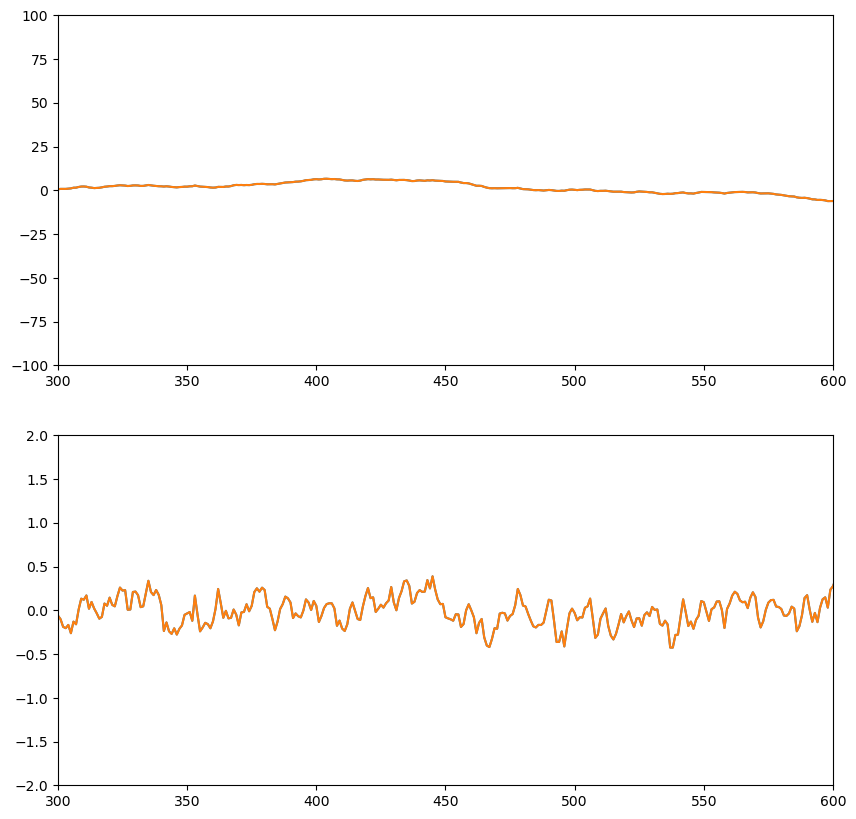

In [5]:
fig, ax = plt.subplots(2,1, figsize=(10,10))
ax[0].plot(defres['CPU'][solverCPU][key][0].real.flatten())
ax[0].plot(defres['GPU'][solverGPU][key][0].real.flatten())
ax[0].set_xlim(0,2e6)
ax[0].set_xlim(300,600)
ax[0].set_ylim(-100,100)

ax[1].plot(defres['CPU'][solverCPU][key][0].imag.flatten())
ax[1].plot(defres['GPU'][solverGPU][key][0].imag.flatten())
ax[1].set_xlim(0,2e6)
ax[1].set_xlim(300,600)
ax[1].set_ylim(-2,2)
# plt.imshow(defres['GPU'][solverGPU][key][0][::2,::2].real)

(1, 1032, 2048) (2113536,)


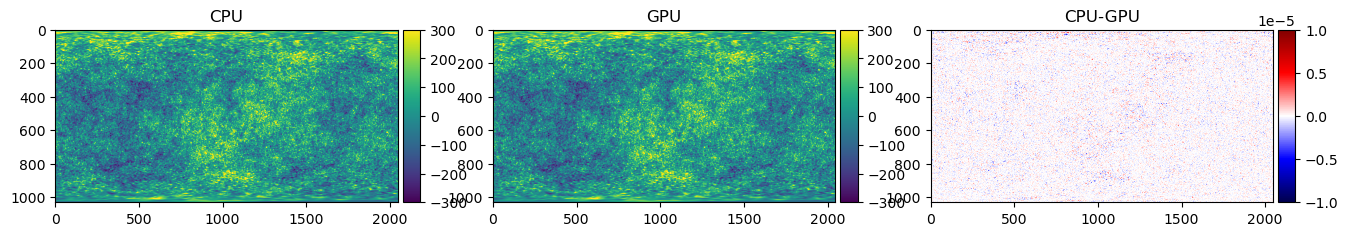

In [4]:
key = 'adjointdoubling'
solverCPU, solverGPU = 'duccnufft', 'cufinufft'
fig, ax = plt.subplots(1,3, figsize=(16,4))
print(defres['CPU'][solverCPU][key][0].shape, defres['GPU'][solverGPU][key][0].shape)

vmin, vmax = -3e2, 3e2
im = ax[0].imshow(defres['CPU'][solverCPU][key][0][0], vmin=vmin, vmax=vmax)
ax[0].set_title('CPU')
divider = make_axes_locatable(ax[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

im = ax[1].imshow(defres['GPU'][solverGPU][key][0].reshape(-1,t.constructor.nphi), vmin=vmin, vmax=vmax)
ax[1].set_title('GPU')
divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

vmin, vmax = -1e-5, 1e-5
im = ax[2].imshow(defres['CPU'][solverCPU][key][0][0]-defres['GPU'][solverGPU][key][0].reshape(-1,t.constructor.nphi), cmap='seismic', vmin=vmin, vmax=vmax)
ax[2].set_title('CPU-GPU')
divider = make_axes_locatable(ax[2])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')


(524800,)


/tmp/ipykernel_1379305/1226785566.py:22: RuntimeWarning: divide by zero encountered in divide
  ax[1].plot(hp.alm2cl(defres['CPU'][solverCPU][key][0][0])/hp.alm2cl(toyunllm), label=solverCPU)
/tmp/ipykernel_1379305/1226785566.py:23: RuntimeWarning: divide by zero encountered in divide
  ax[1].plot(hp.alm2cl(defres['GPU'][solverGPU][key][0])/hp.alm2cl(toyunllm), label=solverGPU)
/tmp/ipykernel_1379305/1226785566.py:25: RuntimeWarning: divide by zero encountered in divide
  ax[1].plot(hp.alm2cl(tlm_unl_1.astype(complex))/hp.alm2cl(toyunllm), label='Juliens test: adjoint_synth(Tlen)')


[]

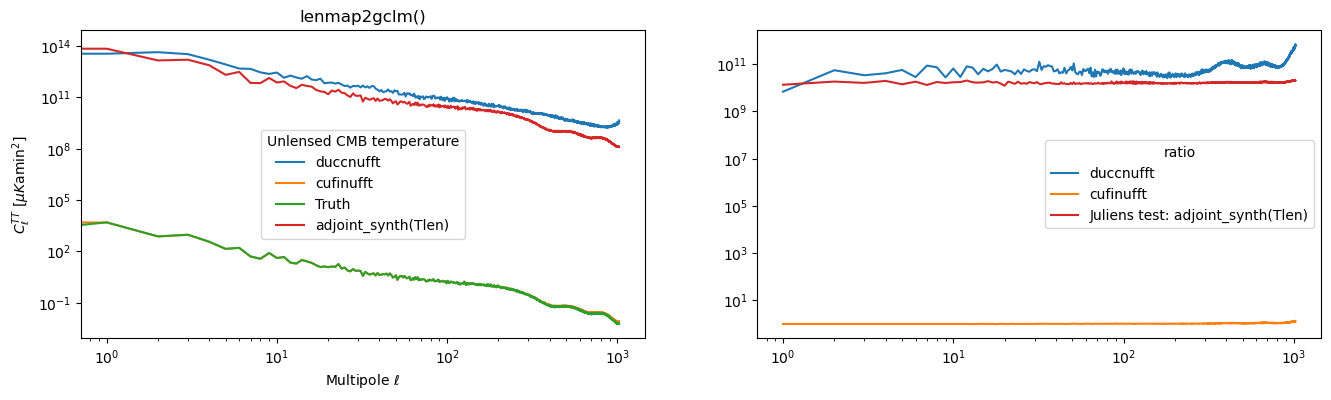

In [5]:
key = 'adjointsynthesis'
solverCPU, solverGPU = 'duccnufft', 'cufinufft'
vmin=-1e-10
vmax=1e-10
fig, ax = plt.subplots(1,2, figsize=(16,4))
print(defres['CPU'][solverCPU][key][0][0].shape)

ax[0].plot(hp.alm2cl(defres['CPU'][solverCPU][key][0][0]), label=solverCPU)
ax[0].plot(hp.alm2cl(defres['GPU'][solverGPU][key][0]), label=solverGPU)
ax[0].plot(hp.alm2cl(toyunllm), label='Truth')

ax[0].plot(hp.alm2cl(tlm_unl_1.astype(complex)), label='adjoint_synth(Tlen)')
# ax[0].plot(hp.alm2cl(tlm_unl_2.astype(complex)), label='adjoint_synth(Tlen*A)')

ax[0].legend(title='Unlensed CMB temperature')
ax[0].loglog()
ax[0].set_title('lenmap2gclm()')

ax[0].set_xlabel(r'Multipole $\ell$')
ax[0].set_ylabel(r'$C_\ell^{TT}\ [\mu K {\rm amin}^2]$')

ax[1].plot(hp.alm2cl(defres['CPU'][solverCPU][key][0][0])/hp.alm2cl(toyunllm), label=solverCPU)
ax[1].plot(hp.alm2cl(defres['GPU'][solverGPU][key][0])/hp.alm2cl(toyunllm), label=solverGPU)
ax[1].plot(0,0)
ax[1].plot(hp.alm2cl(tlm_unl_1.astype(complex))/hp.alm2cl(toyunllm), label='Juliens test: adjoint_synth(Tlen)')
ax[1].legend(title='ratio')
# ax[1].set_ylim(1e0,1e14)
ax[1].loglog()
# ax[1].plot(hp.alm2cl(), label=solverGPU)

In [18]:
hp.alm2cl(toyunllm)-hp.alm2cl(tlm_unl_1.astype(complex))

array([-1.89355592e+13, -6.68533749e+13, -1.38535198e+13, ...,
       -1.29011021e+08, -1.33742438e+08, -1.22999607e+08])

In [ ]:
print()